# INTRODUCTION

Loan default prediction is a common problem for various financial companies and a well defined and known problem in data science. This is the type of problem banks (e.g Goldman Sachs), credit card companies (e.g. Visa), micro-credit banks (e.g. Grameen Bank) or FinTech companies (e.g. Lending Club) face whenever customers ask for a loan.



# Problem Statement

If a model is able to identify credit-worthy customers that were not recognized by traditional credit scores while minimizing their risk of default on the loans, this can be a lucrative niche market or micro-market.


The loan default prediction is a problem of binary classification (do we lend or not). We will at first need to understand the data and we will achieve our goal of better understanding by analyzing the data with the data dictionary. This will give us a sense of what is relevant or which columns could be reworked to build features if necessary. We also expect to clean the dataset because it is common to find data with a sizeable amount of missing values or  trivial rows and columns. One recurring problem in binary classification is the possibility of class imbalance, or outcome imbalance.

The dataset is taken from https://data.world/jaypeedevlin/lending-club-loan-data-2007-11

There are 42538 rows and 111 columns in the dataset.

In this project, we will analyze a dataset containing data on potential borrowers. The goal of this project is to build a model predicting the loan default of potential borrowers.

### Connecting to the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Libraries

In [ ]:
#importing necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_score, recall_score, f1_score, confusion_matrix,matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

import seaborn as sns

%matplotlib inline

### Outlier Detection Function

In [ ]:
def outlier_removal(dataframe,dataframe1,limit = 1.5):
  for col in dataframe1:
    rw = limit*(dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25)) + dataframe[col].quantile(0.75)
    lw = dataframe[col].quantile(0.25) - limit*(dataframe[col].quantile(0.75) - dataframe[col].quantile(0.25))

    dataframe = dataframe[~(dataframe[col]>rw)]
    dataframe = dataframe[~(dataframe[col]<lw)]
    dataframe = dataframe

    return dataframe

### Calling the Data

In [ ]:
#importing the dataset
df = pd.read_csv("/content/drive/MyDrive/LoanStats3a_.csv", low_memory = False, skiprows = 1)

print(df.shape)

print(df.columns)

df.head(2)

(42538, 111)
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
#Loooking at the first row of the dataframe in order to understand the columns
df.iloc[0]

id                              1077501
member_id                     1296599.0
loan_amnt                        5000.0
funded_amnt                      5000.0
funded_amnt_inv                  4975.0
                                ...    
tax_liens                           0.0
tot_hi_cred_lim                     NaN
total_bal_ex_mort                   NaN
total_bc_limit                      NaN
total_il_high_credit_limit          NaN
Name: 0, Length: 111, dtype: object

In [ ]:
df.desc.head(2)

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
Name: desc, dtype: object

In [ ]:
df.url.head(2)

0    https://lendingclub.com/browse/loanDetail.acti...
1    https://lendingclub.com/browse/loanDetail.acti...
Name: url, dtype: object

As we can see, the number of columns will be something to work on. We will remove the *desc* and *url* columns mostly because it leads to or describes information that is not necessary for our analysis.

In [ ]:
df1 = df.drop(['desc','url'],axis=1)

In [ ]:
df1.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,4.253500e+04,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42506.000000,15609.000000,...,0.0,0.0,0.0,0.0,41170.000000,42430.000000,0.0,0.0,0.0,0.0
mean,8.257026e+05,11089.722581,10821.585753,10139.830603,322.623063,6.913656e+04,13.373043,0.152449,1.081424,35.017618,...,NaN,NaN,NaN,NaN,0.045227,0.000024,NaN,NaN,NaN,NaN
std,2.795409e+05,7410.938391,7146.914675,7131.686447,208.927216,6.409635e+04,6.726315,0.512406,1.527455,22.418427,...,NaN,NaN,NaN,NaN,0.208737,0.004855,NaN,NaN,NaN,NaN
min,7.047300e+04,500.000000,500.000000,0.000000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,6.384795e+05,5200.000000,5000.000000,4950.000000,165.520000,4.000000e+04,8.200000,0.000000,0.000000,17.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,8.241780e+05,9700.000000,9600.000000,8500.000000,277.690000,5.900000e+04,13.470000,0.000000,1.000000,33.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,1.033946e+06,15000.000000,15000.000000,14000.000000,428.180000,8.250000e+04,18.680000,0.000000,2.000000,51.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
max,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,13.000000,33.000000,120.000000,...,NaN,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN


## Removal of NULL Data

Another notable thing to remove is to remove columns with more than 50% missing values. It would be time consuming and inefficient to deal with the tremendous amount of missing values from these columns.

In [ ]:
df1.isnull().sum()

id                                0
member_id                         3
loan_amnt                         3
funded_amnt                       3
funded_amnt_inv                   3
                              ...  
tax_liens                       108
tot_hi_cred_lim               42538
total_bal_ex_mort             42538
total_bc_limit                42538
total_il_high_credit_limit    42538
Length: 109, dtype: int64

In [ ]:
df1.shape

(42538, 109)

In [ ]:
# count half point of the dataset.
half_point = len(df1) / 2
df2 = df1.dropna(thresh=half_point, axis=1) #dropping those columns with more than 50% null values
df2.shape

(42538, 52)

NOTE: Dropped those columns whose number of missing values is more than 50%.

## Removal of Unuseful Variables

In [ ]:
df2['emp_title'].value_counts()

US Army                             139
Bank of America                     115
IBM                                  72
Kaiser Permanente                    61
AT&T                                 61
                                   ... 
Regional Elite Airlines Services      1
Mass General Medical Group            1
Kontera                               1
Southeast Georgia Health ystem        1
Homemaker                             1
Name: emp_title, Length: 30658, dtype: int64

NOTE: There are so many different categories in 'emp_title' with very few count in each of the categories and grouping them is also not possible since they are quite distinct. Also, keeping this variable would unnecessarily increase the number of columns after one-hot encoding and also, keeping this variable does not make much sense on the target variable. 



In [ ]:
df2.last_pymnt_d.value_counts()

Mar-2013    1070
Dec-2014     949
May-2013     943
Feb-2013     906
Mar-2012     893
            ... 
Jun-2008      20
Mar-2008      18
Jan-2008      11
Feb-2008       8
Dec-2007       2
Name: last_pymnt_d, Length: 109, dtype: int64

In [ ]:
df2.zip_code.value_counts()

100xx    649
945xx    559
606xx    548
112xx    538
070xx    503
        ... 
823xx      1
965xx      1
388xx      1
386xx      1
036xx      1
Name: zip_code, Length: 837, dtype: int64

NOTE: "issue_d" is the date on which the loan was issued. This variable should not have any impact on whether the borrower would default the loan or not.

recoveries:post charge off gross recovery - this variable is talking about after charge-off gross recovery which is not important

collection_recovery_fee: post charge off collection fee - this is also referring to after charge off recovery fee

last_pymnt_d: Last month payment was received - again, the last payment date is not important



In [ ]:
#removing the id columns and the other non-important columns
df3 = df2.drop(['id', 'member_id', 'emp_title',
                'issue_d','zip_code', 'recoveries', 'collection_recovery_fee','last_pymnt_d'], axis = 1)

df3.shape

(42538, 44)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42535 non-null  float64
 1   funded_amnt                 42535 non-null  float64
 2   funded_amnt_inv             42535 non-null  float64
 3   term                        42535 non-null  object 
 4   int_rate                    42535 non-null  object 
 5   installment                 42535 non-null  float64
 6   grade                       42535 non-null  object 
 7   sub_grade                   42535 non-null  object 
 8   emp_length                  41423 non-null  object 
 9   home_ownership              42535 non-null  object 
 10  annual_inc                  42531 non-null  float64
 11  verification_status         42535 non-null  object 
 12  loan_status                 42535 non-null  object 
 13  pymnt_plan                  425

### Defining TARGET

In [ ]:
df3['loan_status'].value_counts()

Fully Paid                                             34085
Charged Off                                             5662
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Current                                                   19
Late (31-120 days)                                         9
In Grace Period                                            8
Late (16-30 days)                                          2
Default                                                    1
Name: loan_status, dtype: int64

Although we have multiple categories in loan status, we don't need them all. 
The only two categories important for our study of interest are **Fully Paid** and **Charged Off**.

Here **Fully Paid** means the loan has been fully paid by the lender,

and **Charged Off** means the loan that a company believes it will no longer collect as the lender has become delinquent on payments.

So, here we take only these two categories, and lay off the rest.

NOTE: Loans that are in "Default" are loans for which borrowers have failed to make payments for an extended period of time. A loan becomes “Charged Off” when there is no longer a reasonable expectation of further payments.

Here, we just have one value for Default and hence we would not be able to make any predictions based on just 1 default customer data. So we drop that as well.

In [ ]:
df4 = df3[(df3['loan_status'] == "Fully Paid") | (df3['loan_status'] == "Charged Off")]

df4.shape

(39747, 44)

In [ ]:
df4.loan_status.value_counts()

Fully Paid     34085
Charged Off     5662
Name: loan_status, dtype: int64

In [ ]:
# Assigning 0 and 1 to the loan status as per our interest. This variable will serve as our target variable

target_replace = {
    "loan_status" : { "Fully Paid": 0,"Charged Off": 1}
}
df4 = df4.replace(target_replace)

df4['loan_status'].value_counts()

0    34085
1     5662
Name: loan_status, dtype: int64

## DATA CLEANING

Single value columns are not information that help our model, it does not provide any insight into the likelihood of default or repayment, and will be removed from the dataset.

In [ ]:
orig_columns = df4.columns
drop_columns = []
for col in orig_columns:
    col_series = df4[col].dropna().unique()
    if len(col_series) == 1:
        drop_columns.append(col)

drop_columns

['pymnt_plan',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tax_liens']

In [ ]:
df4.pymnt_plan.value_counts()

n    39747
Name: pymnt_plan, dtype: int64

In [ ]:
df4.policy_code.value_counts()

1.0    39747
Name: policy_code, dtype: int64

In [ ]:
#dropping the single-valued columns
df5 = df4.drop(drop_columns, axis = 1)

#### Missing Value Detection

In [ ]:
null_counts = (df5.isnull().sum()/df5.shape[0])*100
null_counts

loan_amnt               0.000000
funded_amnt             0.000000
funded_amnt_inv         0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_length              2.707123
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.027675
addr_state              0.000000
dti                     0.000000
delinq_2yrs             0.000000
earliest_cr_line        0.000000
inq_last_6mths          0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.125796
total_acc               0.000000
total_pymnt             0.000000
total_pymnt_inv         0.000000
total_rec_prncp         0.000000
total_rec_int           0.000000
total_rec_late_fee      0.000000
last_pymnt

We have 4 columns with missing values: 2 with last_credit_pull_d, 10 with title, 50 with revol_util and 697 with pub_rec_bankruptcies and emp_length. Instead of removing the columns as we did earlier, we will remove the rows.

Since here, in these columns, the percentage of missing values is less than 5%, so we can simple drop the rows.

In [ ]:
df5.shape

(39747, 33)

In [ ]:
df6 = df5.copy()
df7 = df6.dropna(axis=0)

df7.shape

(37916, 33)

# Exploratory Data Analysis

In [ ]:
numeric_cols=df7.select_dtypes('float64').columns
numeric_cols

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies'],
      dtype='object')

In [ ]:
str_cols=df7.select_dtypes('object').columns
str_cols

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'title',
       'addr_state', 'earliest_cr_line', 'revol_util', 'last_credit_pull_d'],
      dtype='object')

In [ ]:
df7[str_cols].head(2)

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,B,B2,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Dec-2016
1,60 months,15.27%,C,C4,< 1 year,RENT,Source Verified,car,bike,GA,Apr-1999,9.4%,Oct-2016


In [ ]:
df7["int_rate"] = df7["int_rate"].str.rstrip("%").astype("float")
df7["revol_util"] = df7["revol_util"].str.rstrip("%").astype("float")

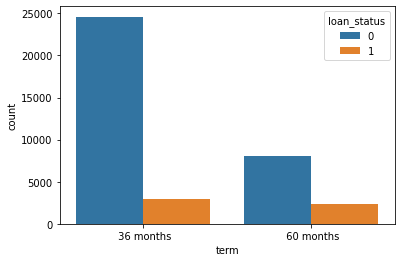

In [ ]:
sns.countplot(data = df7, x = 'term', hue = 'loan_status')
sns.set(rc={'figure.figsize':(13,10)})


The variable *'term'* stands for The number of payments on the loan.


In [ ]:
df7['emp_length'].value_counts()

10+ years    8767
< 1 year     4407
2 years      4303
3 years      4029
4 years      3384
5 years      3246
1 year       3144
6 years      2192
7 years      1748
8 years      1455
9 years      1241
Name: emp_length, dtype: int64

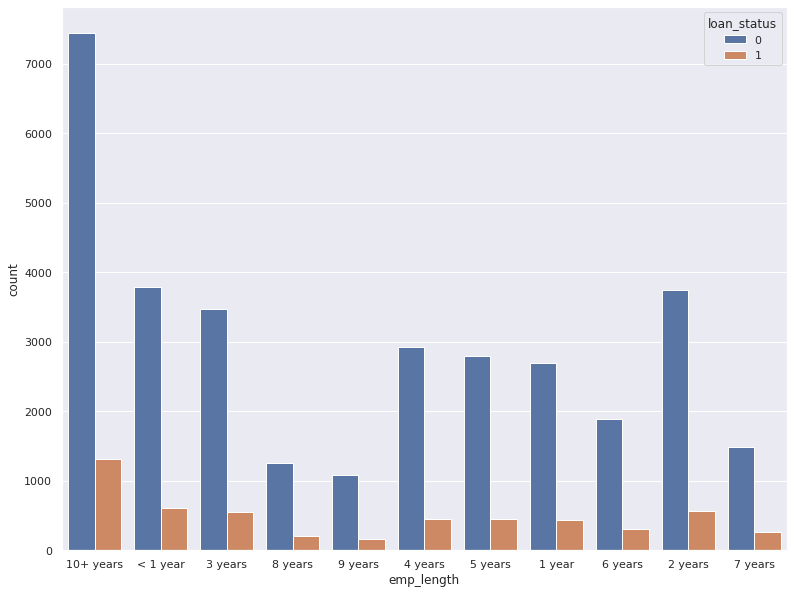

In [ ]:
sns.countplot(data = df7, x = 'emp_length', hue = 'loan_status')
sns.set(rc={'figure.figsize':(13,10)})

From the above graph, we can clearly see that employees having 10+ years of experience tend to pay off their loan more. 

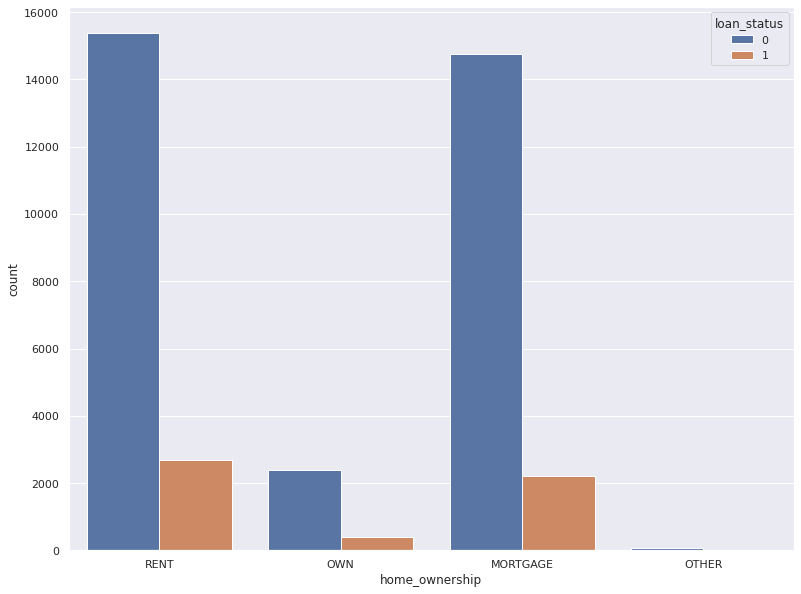

In [ ]:
sns.countplot(data = df7, x = 'home_ownership', hue = 'loan_status')
sns.set(rc={'figure.figsize':(13,10)})

NOTE: RENT category has more "Fully Paid" borrowers.

In [ ]:
df7.purpose.unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

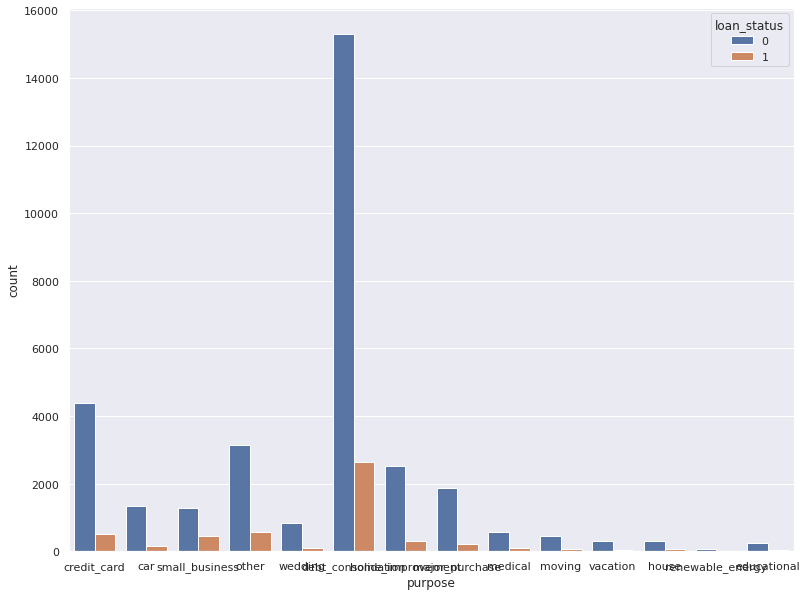

In [ ]:
sns.countplot(data = df7, x = 'purpose', hue = 'loan_status')
sns.set(rc={'figure.figsize':(25,18)})

NOTE: When the purpose of loan is debt consolidation, both fully paid and charged off numbers are the highest.

In [ ]:
numeric_cols=df7.select_dtypes('float64').columns
numeric_cols

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies'],
      dtype='object')

We will choose 4 variables at a time, and check thier distribution individually, to know more about them on an univariate level.

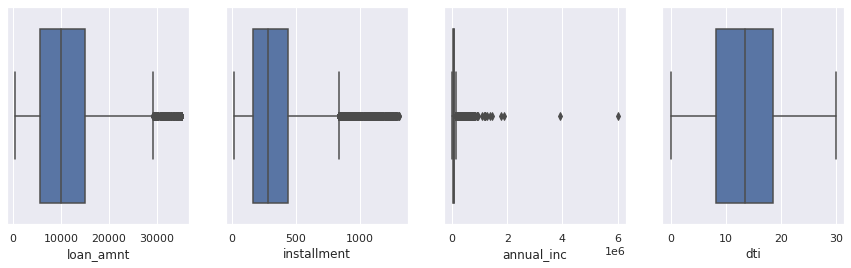

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
sns.boxplot(x = 'loan_amnt', data=df7, ax=axes[0])
sns.boxplot(x='installment', data=df7, ax=axes[1])
sns.boxplot(x = 'annual_inc', data=df7, ax=axes[2])
sns.boxplot(x='dti', data=df7, ax=axes[3])

Although we can see several outliers in *annual_inc*, which means the self-reported annual income provided by the borrower during registration, 
the outliers can be high-end customers, whom we don't want to exclude, hence we are not excluding the outliers here.

Similar logic is applied on *loan_amnt*, and *installment* variables

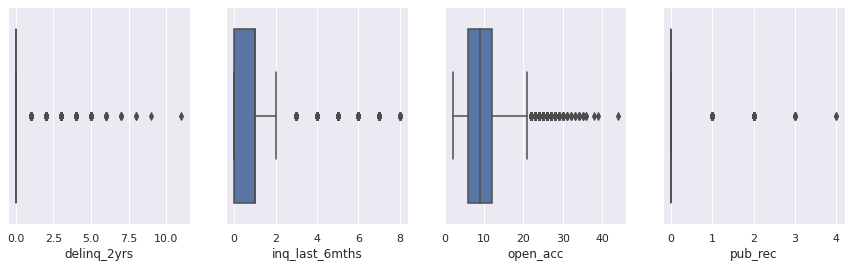

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
sns.boxplot(x = 'delinq_2yrs', data=df7, ax=axes[0])
sns.boxplot(x='inq_last_6mths', data=df7, ax=axes[1])
sns.boxplot(x = 'open_acc', data=df7, ax=axes[2])
sns.boxplot(x='pub_rec', data=df7, ax=axes[3])

*delinq_2yrs* stands for the number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years. 

*inq_last_6mnths* stands for the number of inquiries in past 6 months. 

*open_acc* means the number of open credit lines in the borrower's credit file.

*pub_req* means number of derogatory public records.

Now, we can remove the outliers for these variables, since they are some extreme cases, in some cases might be misreported.

In [ ]:
col = ['delinq_2yrs','inq_last_6mths', 'open_acc', 'pub_rec']

df7 = outlier_removal(df7,df7[col], limit = 3)

df7.shape

(33808, 33)

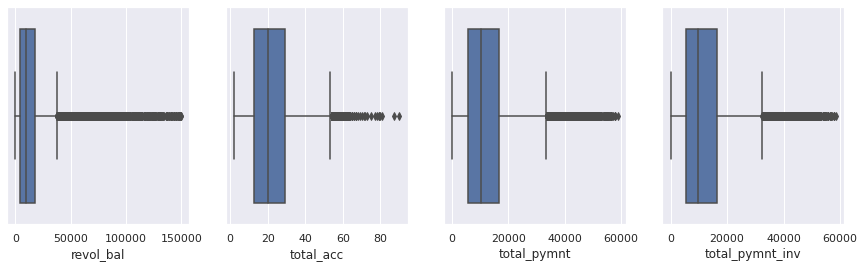

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
sns.boxplot(x = 'revol_bal', data=df7, ax=axes[0])
sns.boxplot(x='total_acc', data=df7, ax=axes[1])
sns.boxplot(x = 'total_pymnt', data=df7, ax=axes[2])
sns.boxplot(x='total_pymnt_inv', data=df7, ax=axes[3])

*revol_bal* means Total credit revolving balance

*total_acc* stands for the total number of credit lines currently in the borrower's credit file.

*total_pymnt* means Payments received to date for total amount funded

*total_pymnt_inv* stands for Payments received to date for portion of total amount funded by investors.

Although there are some outliers, we will not remove any, since they are payment variables, and higher payment can mean high-end customers.

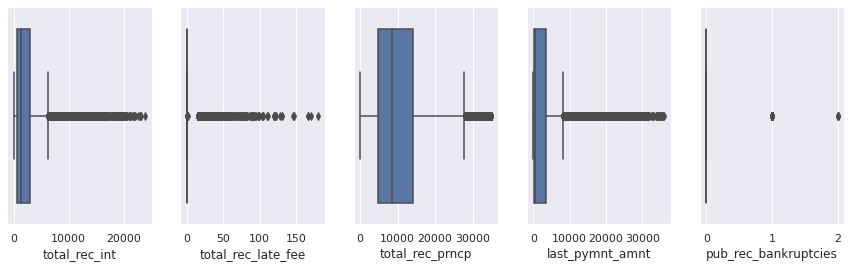

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
sns.boxplot(x = 'total_rec_int', data=df7, ax=axes[0])
sns.boxplot(x='total_rec_late_fee', data=df7, ax=axes[1])
sns.boxplot(x='total_rec_prncp', data=df7, ax=axes[2])
sns.boxplot(x='last_pymnt_amnt', data=df7, ax=axes[3])
sns.boxplot(x='pub_rec_bankruptcies', data=df7, ax=axes[4])

*total_rec_late_fee* stands for Late fees received to date. 

*total_rec_int* means Interest received to date. 

*total_rec_prncp* : Principal received to date

*last_pymnt_amnt*: Last total payment amount received

*pub_rec_bankruptcies*: Number of public record bankruptcies

We will again not remove the outliers from *total_rec_late_fee*, since it can help us identify the Charged off cases.



In [ ]:
col = ['pub_rec_bankruptcies']

df7 = outlier_removal(df7,df7[col], limit = 3)

df7.shape

(32408, 33)

#### Handling Categorical Variables

In [ ]:
print(df7.dtypes.value_counts())

float64    21
object     11
int64       1
dtype: int64


In [ ]:
obj_cols = df7.select_dtypes(include=["object"]).columns
obj_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'title', 'addr_state',
       'earliest_cr_line', 'last_credit_pull_d'],
      dtype='object')

In [ ]:
for col in obj_cols:
  print(df7[col].value_counts())

 36 months    23616
 60 months     8792
Name: term, dtype: int64
B    9981
A    9074
C    6308
D    3954
E    2142
F     734
G     215
Name: grade, dtype: int64
A4    2604
A5    2443
B3    2443
B5    2195
B4    2071
B2    1728
C1    1688
A3    1636
C2    1615
B1    1544
A2    1366
C3    1191
A1    1025
D2    1006
C4     942
C5     872
D3     870
D4     741
D5     672
D1     665
E1     603
E2     485
E3     407
E4     335
E5     312
F1     231
F2     186
F3     129
F4     110
F5      78
G1      69
G2      51
G4      41
G3      29
G5      25
Name: sub_grade, dtype: int64
10+ years    7240
< 1 year     3859
2 years      3727
3 years      3491
4 years      2952
5 years      2843
1 year       2679
6 years      1885
7 years      1475
8 years      1203
9 years      1054
Name: emp_length, dtype: int64
RENT        15665
MORTGAGE    14299
OWN          2371
OTHER          73
Name: home_ownership, dtype: int64
Not Verified       13494
Verified           10579
Source Verified     8335
Name: verific

**NOTE -** 
1. We will remove the addr_state because if we were to encode all these variables, we would make our dataframe quite large and would slow the computation done by our machine learning algorithm.

2. We will keep Purpose Column and remove Title, since, both of the columns have same information, where title containing a lot of the same just under a different form

3. *earliest_cr_line*: The month the borrower's earliest reported credit line was opened

and *last_credit_pull_d*: The most recent month LC pulled credit for this loan;

can be dropped since they will not help us much.

4. We will encode the variable emp_length

In [ ]:
df7['emp_length'].value_counts()

10+ years    7240
< 1 year     3859
2 years      3727
3 years      3491
4 years      2952
5 years      2843
1 year       2679
6 years      1885
7 years      1475
8 years      1203
9 years      1054
Name: emp_length, dtype: int64

In [ ]:
map_emp_lngth = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0}
}
df8 = df7.drop(["last_credit_pull_d", "earliest_cr_line", "addr_state", "title"], axis=1)
df8 = df8.replace(map_emp_lngth)
df8=df8.drop('emp_length',axis=1)

In [ ]:
obj_cols = df8.select_dtypes(include=["object"]).columns
obj_cols

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose'],
      dtype='object')

In [ ]:
categorical_columns = ["home_ownership", "verification_status", "purpose", "term",'grade','sub_grade']
dummy_df = pd.get_dummies(df8[categorical_columns])
df9 = pd.concat([df8, dummy_df], axis=1)
df10 = df9.drop(categorical_columns, axis=1)

df10.shape

df10.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
0,5000.0,5000.0,4975.0,10.65,162.87,24000.0,0,27.65,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,2500.0,2500.0,15.27,59.83,30000.0,1,1.00,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,2400.0,2400.0,15.96,84.33,12252.0,0,8.72,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,10000.0,10000.0,13.49,339.31,49200.0,0,20.00,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
5,5000.0,5000.0,5000.0,7.90,156.46,36000.0,0,11.20,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0


# Model Fitting

In [ ]:
print(df10['loan_status'].value_counts())
np.round(df10['loan_status'].value_counts()*100/df10.shape[0],2)

0    28055
1     4353
Name: loan_status, dtype: int64


0    86.57
1    13.43
Name: loan_status, dtype: float64

Metric for comparison

**F1 score** will be used as the performance metric for comparison.

Since the data is largely imbalanced, accuracy cannot be taken into consideration as a metric for comparison between models.

Both precision and recall can be used for comparison, however, since F1 score is the harmonic mean of precision and recall, so it contains the essence of both precision and recall.

Formula for F1 score: (2 * precision * recall)/(precision+recall)


Therefore, in this project, F1 score has been considered as the metric for comparison across different models.

In [ ]:
from sklearn.model_selection import train_test_split

X = df10.drop(['loan_status'],axis=1)
y = df10.loan_status

print(X.columns)

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size= 0.25, random_state=42)

print("X train shape",X_train.shape)
print("X test shape",X_test.shape)
print("y train shape",y_train.shape)
print("y test shape",y_test.shape)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months', 'grade_A', 'grade_B', 'gra

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32408 entries, 0 to 39071
Data columns (total 86 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            32408 non-null  float64
 1   funded_amnt                          32408 non-null  float64
 2   funded_amnt_inv                      32408 non-null  float64
 3   int_rate                             32408 non-null  float64
 4   installment                          32408 non-null  float64
 5   annual_inc                           32408 non-null  float64
 6   dti                                  32408 non-null  float64
 7   delinq_2yrs                          32408 non-null  float64
 8   inq_last_6mths                       32408 non-null  float64
 9   open_acc                             32408 non-null  float64
 10  pub_rec                              32408 non-null  float64
 11  revol_bal                   

In [ ]:
from sklearn.preprocessing import MinMaxScaler
rs = MinMaxScaler()

X_scaled = pd.DataFrame(rs.fit_transform(X_train))

print(X_scaled.shape)

X_scaled.head()

(24306, 86)


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.095551,0.095551,0.114286,0.328117,0.088729,0.006079,0.301169,0.0,0.000,0.047619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.057622,0.057622,0.077143,0.792906,0.064103,0.001935,0.511185,0.0,0.000,0.023810,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.328957,0.328957,0.342857,0.709963,0.230566,0.005003,0.447746,0.0,0.250,0.095238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,1.000000,1.000000,0.551382,0.957911,0.107405,0.155259,0.0,0.375,0.404762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.219548,0.219548,0.235714,0.107981,0.187108,0.003536,0.807679,0.0,0.000,0.119048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# K-Nearest Neighbourhood Classification Model

In [ ]:
from sklearn.model_selection import KFold 
k = 5
kf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=0)


In [ ]:

k_value_range = 5
validation_score = []
train_score = []

for k in range(1, k_value_range+1):
    print("Result for K value", k)
    acc_score = []
    pre_score = []
    rec_score = []
    f_score = []
    trn_score = []
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    for train_index , test_index in kf.split(X_scaled,y_train):
        X_train1, X_test1 = X_scaled.iloc[train_index,:],X_scaled.iloc[test_index,:]
        y_train1, y_test1 = y.iloc[train_index] , y.iloc[test_index]
     
        knn.fit(X_train1,y_train1)
        trn_score.append(knn.score(X_train1,y_train1))
        pred_values = knn.predict(X_test1)
     
        acc = accuracy_score(pred_values , y_test1)
        acc_score.append(acc)

        pre = precision_score(pred_values , y_test1)
        pre_score.append(pre)

        rec = recall_score(pred_values , y_test1)
        rec_score.append(rec)

        f_sc = f1_score(pred_values , y_test1)
        f_score.append(f_sc)

        
     
    avg_acc_score = sum(acc_score)/len(acc_score)
    avg_train_score = sum(trn_score)/len(trn_score)
    validation_score.append(avg_acc_score)
    train_score.append(avg_train_score)
    print(f"train accuracy Mean: {np.mean(trn_score)}")
    print(f"Accuracy Mean: {np.mean(acc_score)}")
    print(f"Precision Mean: {np.mean(pre_score)}")
    print(f"Recall Mean: {np.mean(rec_score)}")
    print(f"F1 Mean: {np.mean(f_score)}")
    print("\n")



Result for K value 1
train accuracy Mean: 1.0
Accuracy Mean: 0.7631051930398335
Precision Mean: 0.1418590646207009
Recall Mean: 0.1435204642472674
F1 Mean: 0.1425179906473189


Result for K value 2
train accuracy Mean: 0.881414749523287
Accuracy Mean: 0.8471580900339071
Precision Mean: 0.023097704675651386
Recall Mean: 0.160094068063101
F1 Mean: 0.04028952214668481


Result for K value 3
train accuracy Mean: 0.8820135914113314
Accuracy Mean: 0.8217735254336562
Precision Mean: 0.058755827832592436
Recall Mean: 0.14762395962848793
F1 Mean: 0.08389272020929886


Result for K value 4
train accuracy Mean: 0.8662013100331739
Accuracy Mean: 0.8535351165416525
Precision Mean: 0.012314779622986752
Recall Mean: 0.15804199318993534
F1 Mean: 0.022820771508057246


Result for K value 5
train accuracy Mean: 0.8663796009717106
Accuracy Mean: 0.8447308174759154
Precision Mean: 0.0267199167976216
Recall Mean: 0.15483900209388118
F1 Mean: 0.04551225664938302




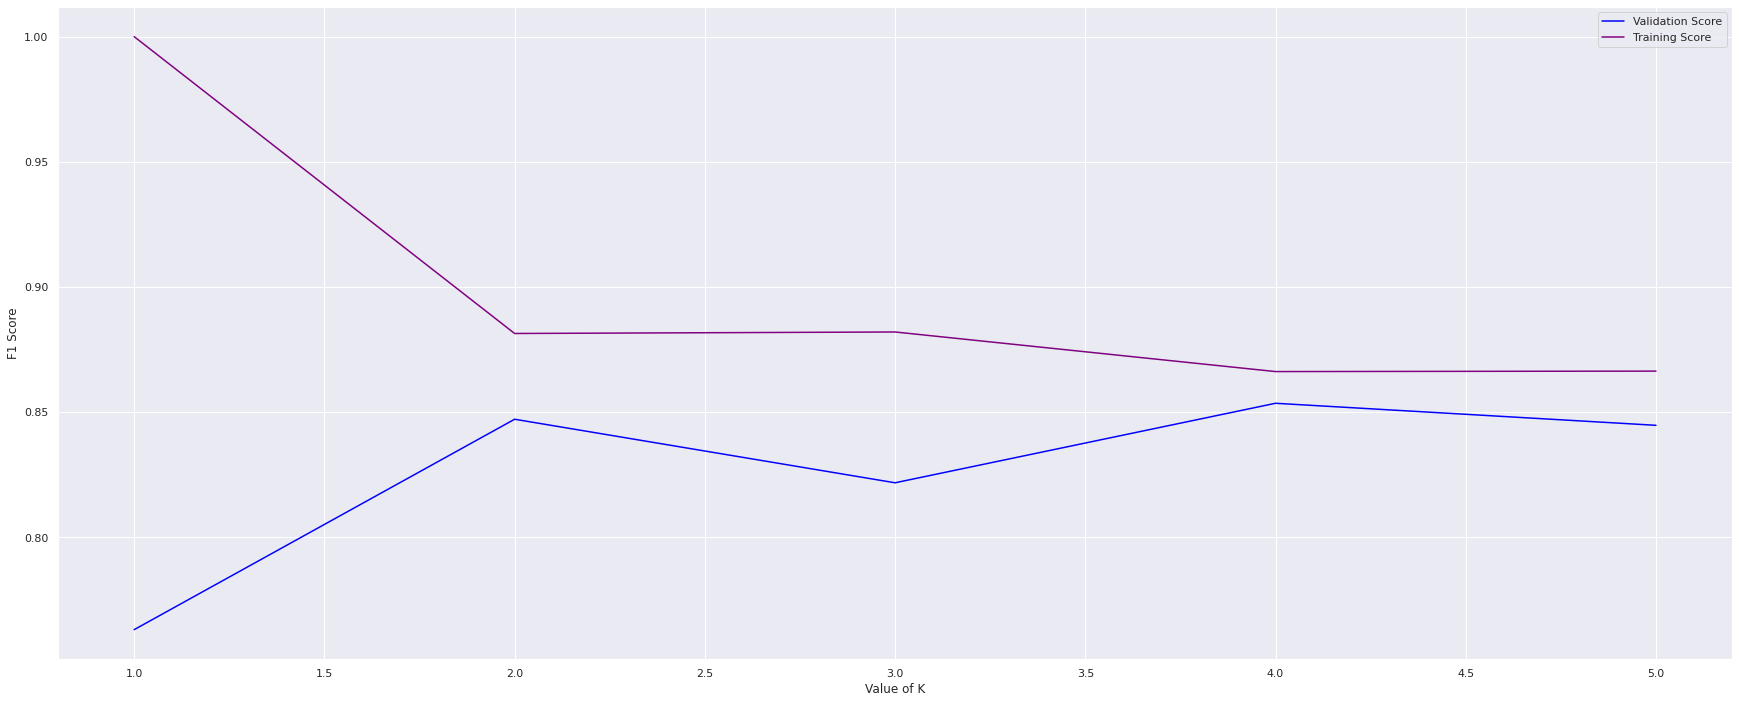

In [ ]:
plt.figure(figsize=(30,12))
plt.plot(np.arange(1,6), validation_score, color="blue", label="Validation Score")
plt.plot(np.arange(1,6), train_score, color="purple", label="Training Score")
plt.xlabel("Value of K")
plt.ylabel("F1 Score")
plt.legend()

NOTE: Difference between train and test scores are minimum at k=5, hence we will consider k=5 in our KNN classifier model.

In [ ]:
print(X_scaled.shape)
print(y_train.shape)

(24306, 86)
(24306,)


In [ ]:
X_train_k = X_scaled.copy()

k_value = 5
knn = KNeighborsClassifier(n_neighbors=k_value)
knn.fit(X_scaled, y_train)

X_pred = knn.predict(X_train_k)
X_train_k['pred'] = X_pred

print('Accuracy Score ->',round(accuracy_score(y_train, X_train_k['pred'])))
print('Precision Score ->',round(precision_score(y_train, X_train_k['pred']),5))
print('Recall Score ->',round(recall_score(y_train, X_train_k['pred']),5))
print('F1 score ->',round(f1_score(y_train, X_train_k['pred']),5))

Accuracy Score -> 1
Precision Score -> 0.85848
Recall Score -> 0.33023
F1 score -> 0.47698


In [ ]:
X_test1 = X_test.copy()

X_test_scaled = rs.transform(X_test1)

X_test_scaled.shape

y_pred = knn.predict(X_test_scaled)

y_prob = knn.predict_proba(X_test_scaled)[:,1]

X_test1['pred'] = y_pred

X_test1['prob'] = y_prob

print('___________________VALIDATION RESULTS__________________________')
print('\n')
print('Accuracy Score ->',round(accuracy_score(y_test, X_test1['pred'])))
print('Precision Score ->',round(precision_score(y_test, X_test1['pred']),5))
print('Recall Score ->',round(recall_score(y_test, X_test1['pred']),5))
print('F1 score ->',round(f1_score(y_test, X_test1['pred']),5))
print('\n')
print('***Confusion Matrix***')
confusion_matrix(y_test, X_test1['pred'])

___________________VALIDATION RESULTS__________________________


Accuracy Score -> 1
Precision Score -> 0.63636
Recall Score -> 0.2179
F1 score -> 0.32464


***Confusion Matrix***


array([[6946,  128],
       [ 804,  224]])

NOTE: The KNN classifier is giving an F1 score of 32.4% which can be tried to improve further using other models.

### NAIVE BAYES CLASSIFICATION MODEL

In [ ]:
from sklearn.naive_bayes import GaussianNB

acc_scores_rf = []
roc_auc_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []
train_acc = []

#Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=0)

#K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_scaled, y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  gnb = GaussianNB()

  gnb.fit(X_scaled.iloc[train], y_train.iloc[train])
  y_pred = gnb.predict(X_scaled.iloc[test])

  acc_scores_rf.append(accuracy_score(y_train.iloc[test], y_pred))

  train_acc.append(accuracy_score(y_train.iloc[train], gnb.predict(X_scaled.iloc[train])))
  roc_auc_scores_rf.append(roc_auc_score(y_train.iloc[test], y_pred))
  precision_scores_rf.append(precision_score(y_train.iloc[test], y_pred))
  recall_scores_rf.append(recall_score(y_train.iloc[test], y_pred))
  f1_scores_rf.append(f1_score(y_train.iloc[test], y_pred))

  fold_no = fold_no + 1
  
print(f"Accuracy Mean: {np.mean(acc_scores_rf)}")
print(f"Accuracy Standard Deviation: {np.std(acc_scores_rf)}")
print("\n")
print(f"ROC-AUC Mean: {np.mean(roc_auc_scores_rf)}")
print(f"ROC-AUC Standard Deviation: {np.std(roc_auc_scores_rf)}")
print("\n")
print(f"Precision Mean: {np.mean(precision_scores_rf)}")
print(f"Precision Standard Deviation: {np.std(precision_scores_rf)}")
print("\n")
print(f"Recall Mean: {np.mean(recall_scores_rf)}")
print(f"Recall Standard Deviation: {np.std(recall_scores_rf)}")
print("\n")
print(f"F1 Mean: {np.mean(f1_scores_rf)}")
print(f"F1 Standard Deviation: {np.std(f1_scores_rf)}")

print(f"train accuracy Mean: {np.mean(train_acc)}")

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...
------------------------------------------------------------------------
Training for fold 6 ...
------------------------------------------------------------------------
Training for fold 7 ...
------------------------------------------------------------------------
Training for fold 8 ...
------------------------------------------------------------------------
Training for fold 9 ...
------------------------------------------------------------------------
Training for fold 10 ...
Accuracy Mean: 0.830082846226

In [ ]:
X_test1 = X_test.copy()

X_test_scaled = rs.transform(X_test1)

X_test_scaled.shape

y_pred = gnb.predict(X_test_scaled)

y_prob = gnb.predict_proba(X_test_scaled)[:,1]

X_test1['pred'] = y_pred

X_test1['prob'] = y_prob

print('___________________VALIDATION RESULTS__________________________')
print('\n')
print('Accuracy Score ->',round(accuracy_score(y_test, X_test1['pred']),))
print('Precision Score ->',round(precision_score(y_test, X_test1['pred']),5))
print('Recall Score ->',round(recall_score(y_test, X_test1['pred']),5))
print('F1 score ->',round(f1_score(y_test, X_test1['pred']),5))
print('\n')
print('***Confusion Matrix***')
confusion_matrix(y_test, X_test1['pred'])



___________________VALIDATION RESULTS__________________________


Accuracy Score -> 1
Precision Score -> 0.39405
Recall Score -> 0.50292
F1 score -> 0.44188


***Confusion Matrix***


array([[6279,  795],
       [ 511,  517]])

NOTE: F1 score has increased in Naive Bayes to 44% which is more than what we got in KNN model.



No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.838


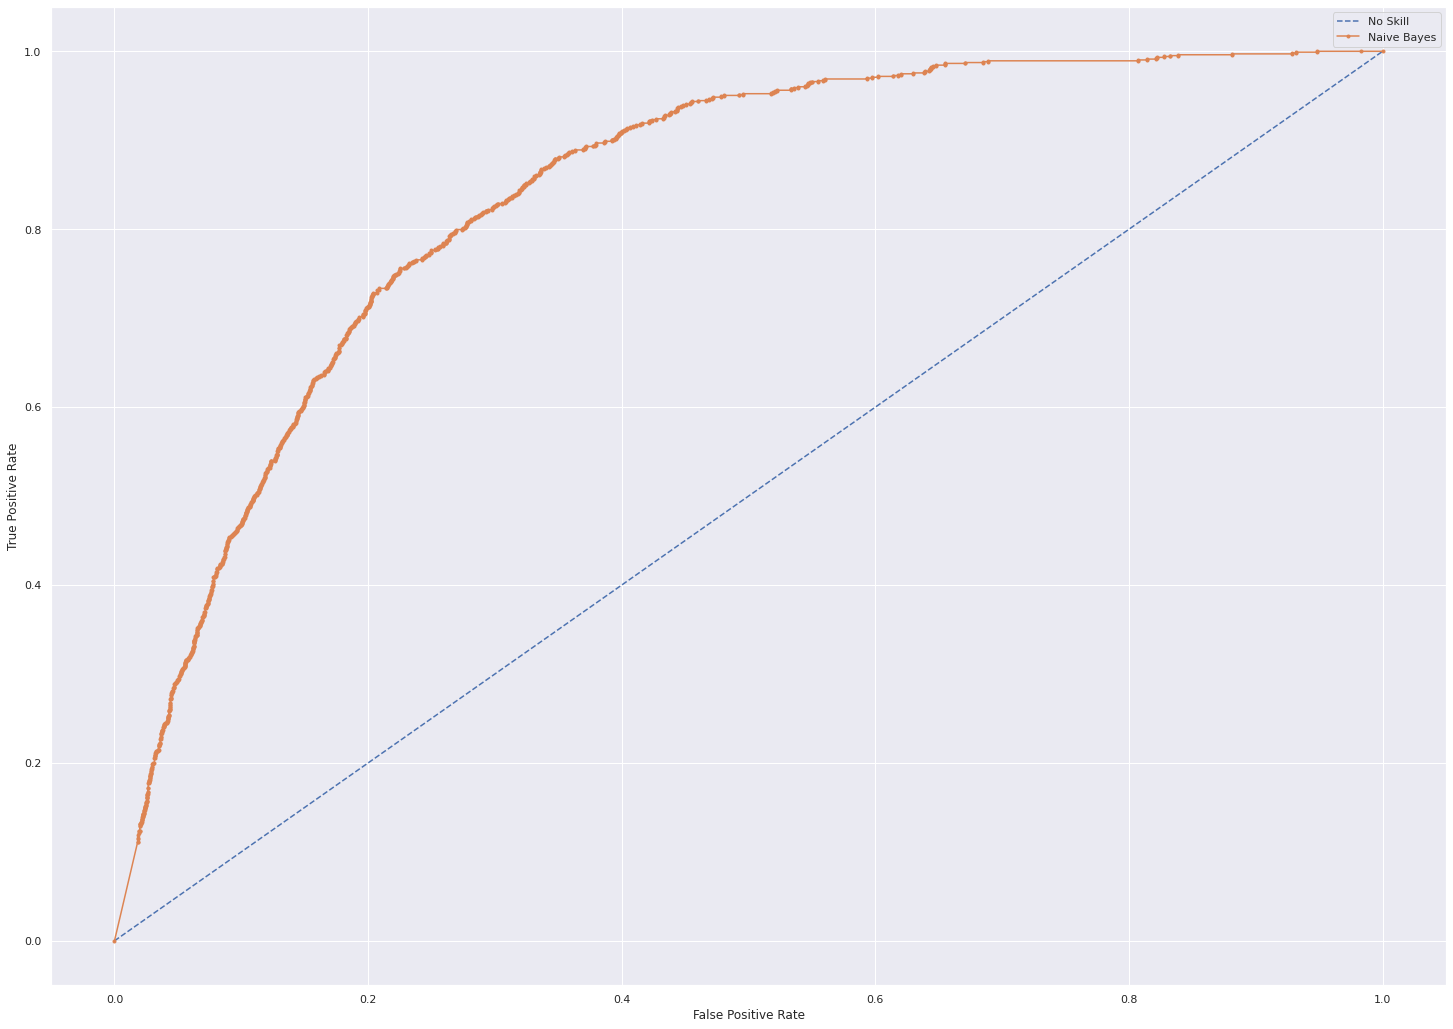

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, y_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Naive Bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Decision Tree Classification Model

In [ ]:
acc_scores_rf = []
roc_auc_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []
train_acc = []

#Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=0)

#K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_scaled, y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  decisiontreeClassifier = DecisionTreeClassifier(class_weight = 'balanced',random_state=42)

  decisiontreeClassifier.fit(X_scaled.iloc[train], y_train.iloc[train])
  y_pred = decisiontreeClassifier.predict(X_scaled.iloc[test])

  acc_scores_rf.append(accuracy_score(y_train.iloc[test], y_pred))

  train_acc.append(accuracy_score(y_train.iloc[train], decisiontreeClassifier.predict(X_scaled.iloc[train])))
  roc_auc_scores_rf.append(roc_auc_score(y_train.iloc[test], y_pred))
  precision_scores_rf.append(precision_score(y_train.iloc[test], y_pred))
  recall_scores_rf.append(recall_score(y_train.iloc[test], y_pred))
  f1_scores_rf.append(f1_score(y_train.iloc[test], y_pred))

  fold_no = fold_no + 1
  
print(f"Accuracy Mean: {np.mean(acc_scores_rf)}")
print(f"Accuracy Standard Deviation: {np.std(acc_scores_rf)}")
print("\n")
print(f"ROC-AUC Mean: {np.mean(roc_auc_scores_rf)}")
print(f"ROC-AUC Standard Deviation: {np.std(roc_auc_scores_rf)}")
print("\n")
print(f"Precision Mean: {np.mean(precision_scores_rf)}")
print(f"Precision Standard Deviation: {np.std(precision_scores_rf)}")
print("\n")
print(f"Recall Mean: {np.mean(recall_scores_rf)}")
print(f"Recall Standard Deviation: {np.std(recall_scores_rf)}")
print("\n")
print(f"F1 Mean: {np.mean(f1_scores_rf)}")
print(f"F1 Standard Deviation: {np.std(f1_scores_rf)}")

print(f"train accuracy Mean: {np.mean(train_acc)}")

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...
------------------------------------------------------------------------
Training for fold 6 ...
------------------------------------------------------------------------
Training for fold 7 ...
------------------------------------------------------------------------
Training for fold 8 ...
------------------------------------------------------------------------
Training for fold 9 ...
------------------------------------------------------------------------
Training for fold 10 ...
Accuracy Mean: 0.991771494059

In [ ]:
X_test1 = X_test.copy()

X_test_scaled = rs.transform(X_test1)

X_test_scaled.shape

y_pred = decisiontreeClassifier.predict(X_test_scaled)

y_prob = decisiontreeClassifier.predict_proba(X_test_scaled)[:,1]

X_test1['pred'] = y_pred

X_test1['prob'] = y_prob

print('___________________VALIDATION RESULTS__________________________')
print('\n')
print('Accuracy Score ->',round(accuracy_score(y_test, X_test1['pred']),))
print('Precision Score ->',round(precision_score(y_test, X_test1['pred']),5))
print('Recall Score ->',round(recall_score(y_test, X_test1['pred']),5))
print('F1 score ->',round(f1_score(y_test, X_test1['pred']),5))
print('\n')
print('***Confusion Matrix***')
confusion_matrix(y_test, X_test1['pred'])



___________________VALIDATION RESULTS__________________________


Accuracy Score -> 1
Precision Score -> 0.97319
Recall Score -> 0.95331
F1 score -> 0.96314


***Confusion Matrix***


array([[7047,   27],
       [  48,  980]])

NOTE: F1 score for Decision Tree has largely improved to 0.96.



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.975


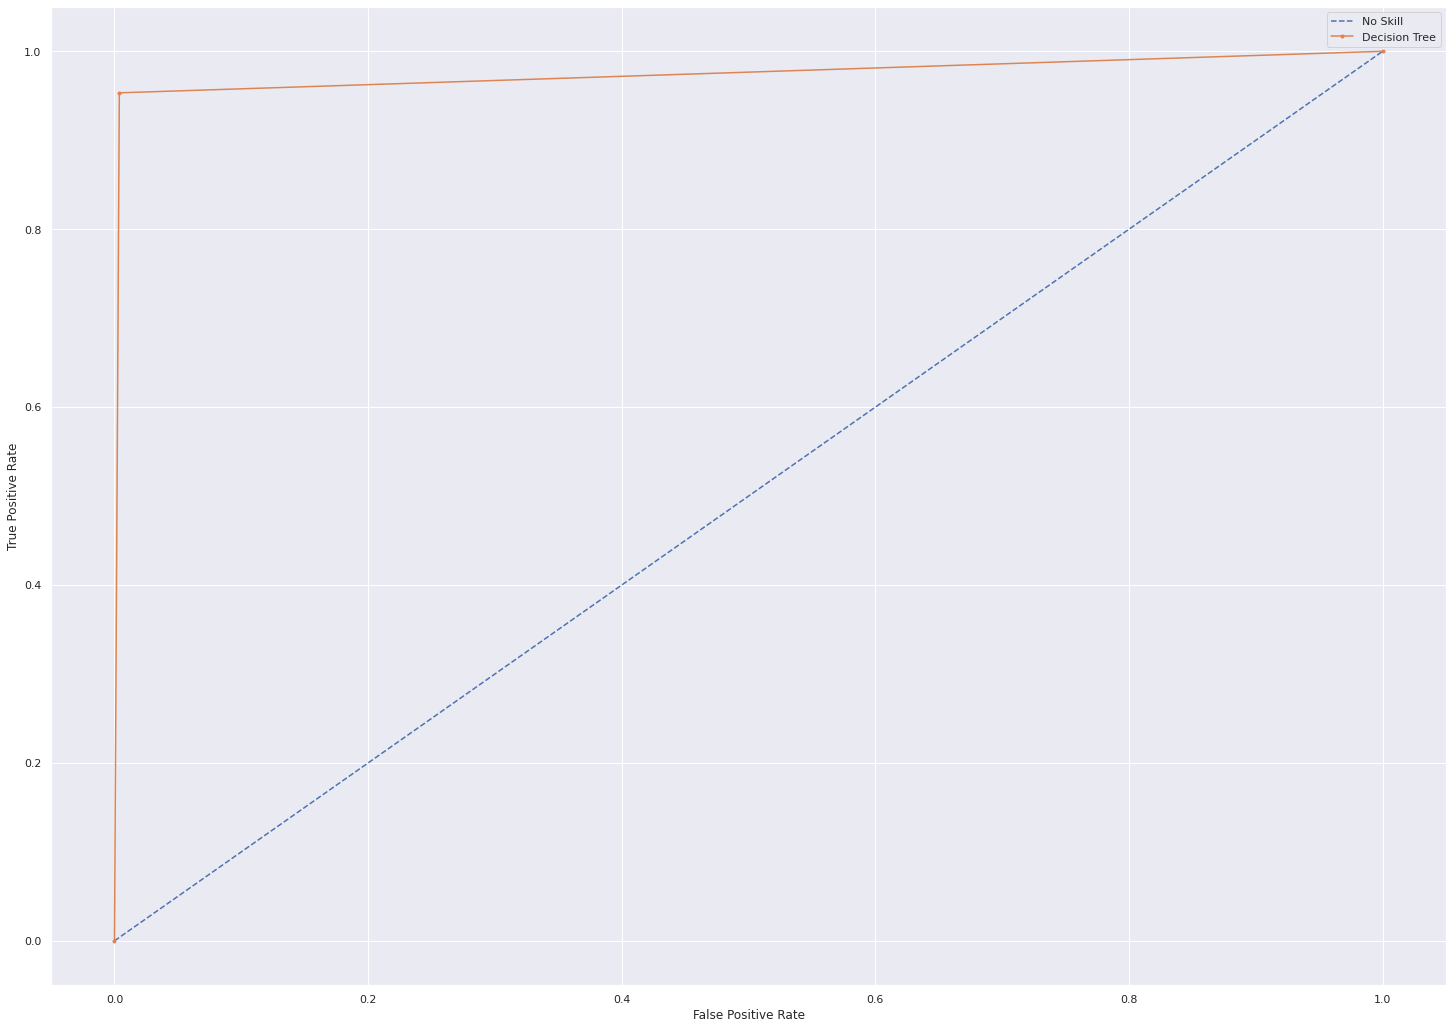

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, y_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

**INFERENCE**

The Decision Tree Classifier is fitted on the scaled data where;
the Precision and Recall scores on training after stratified K fold CV are 0.97 and 0.96, whereas the F1 score came out to be 0.97.
When fitted on the validation data, the Precision and Recall scored are 0.97 and 0.96, the F1 score is 0.96.
We can say that the model has a very good fit, since the results from training and validation are very much close, we can discard the possibility of overfitting or underfitting.

# Feature Importance Plot for Decision Tree model

Text(0.5, 1.0, 'Feature Importance')

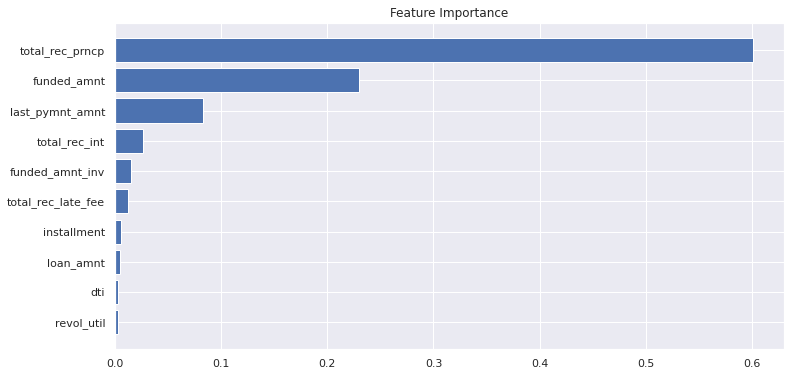

In [ ]:
model=DecisionTreeClassifier(class_weight = 'balanced',random_state=42)
model.fit(X_train,y_train)
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx=sorted_idx[-10:len(sorted_idx)]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test1.columns)[sorted_idx])
plt.title('Feature Importance')

Now let's move on to the next model: Random Forest Classification Model; and check whether it out-performs the previous models

## Random Forest Classification Model

In [ ]:
acc_scores_rf = []
roc_auc_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []
train_acc = []

#Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=0)

#K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_scaled, y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  randomForestClassifier = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

  randomForestClassifier.fit(X_scaled.iloc[train], y_train.iloc[train])
  y_pred = randomForestClassifier.predict(X_scaled.iloc[test])

  acc_scores_rf.append(accuracy_score(y_train.iloc[test], y_pred))

  train_acc.append(accuracy_score(y_train.iloc[train], randomForestClassifier.predict(X_scaled.iloc[train])))
  roc_auc_scores_rf.append(roc_auc_score(y_train.iloc[test], y_pred))
  precision_scores_rf.append(precision_score(y_train.iloc[test], y_pred))
  recall_scores_rf.append(recall_score(y_train.iloc[test], y_pred))
  f1_scores_rf.append(f1_score(y_train.iloc[test], y_pred))

  fold_no = fold_no + 1
  
print(f"Accuracy Mean: {np.mean(acc_scores_rf)}")
print(f"Accuracy Standard Deviation: {np.std(acc_scores_rf)}")
print("\n")
print(f"ROC-AUC Mean: {np.mean(roc_auc_scores_rf)}")
print(f"ROC-AUC Standard Deviation: {np.std(roc_auc_scores_rf)}")
print("\n")
print(f"Precision Mean: {np.mean(precision_scores_rf)}")
print(f"Precision Standard Deviation: {np.std(precision_scores_rf)}")
print("\n")
print(f"Recall Mean: {np.mean(recall_scores_rf)}")
print(f"Recall Standard Deviation: {np.std(recall_scores_rf)}")
print("\n")
print(f"F1 Mean: {np.mean(f1_scores_rf)}")
print(f"F1 Standard Deviation: {np.std(f1_scores_rf)}")

print(f"train accuracy Mean: {np.mean(train_acc)}")

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...
------------------------------------------------------------------------
Training for fold 6 ...
------------------------------------------------------------------------
Training for fold 7 ...
------------------------------------------------------------------------
Training for fold 8 ...
------------------------------------------------------------------------
Training for fold 9 ...
------------------------------------------------------------------------
Training for fold 10 ...
Accuracy Mean: 0.984407084080

In [ ]:
X_test1 = X_test.copy()

X_test_scaled = rs.transform(X_test1)

X_test_scaled.shape

y_pred = randomForestClassifier.predict(X_test_scaled)

y_prob = randomForestClassifier.predict_proba(X_test_scaled)[:,1]

X_test1['pred'] = y_pred

X_test1['prob'] = y_prob

print('___________________VALIDATION RESULTS__________________________')
print('\n')
print('Accuracy Score ->',round(accuracy_score(y_test, X_test1['pred']),))
print('Precision Score ->',round(precision_score(y_test, X_test1['pred']),5))
print('Recall Score ->',round(recall_score(y_test, X_test1['pred']),5))
print('F1 Score ->',round(f1_score(y_test, X_test1['pred']),5))
print('\n')
print('***Confusion Matrix***')
confusion_matrix(y_test, X_test1['pred'])



___________________VALIDATION RESULTS__________________________


Accuracy Score -> 1
Precision Score -> 0.99888
Recall Score -> 0.87062
F1 Score -> 0.93035


***Confusion Matrix***


array([[7073,    1],
       [ 133,  895]])

No Skill: ROC AUC=0.500
RandomForest: ROC AUC=0.999


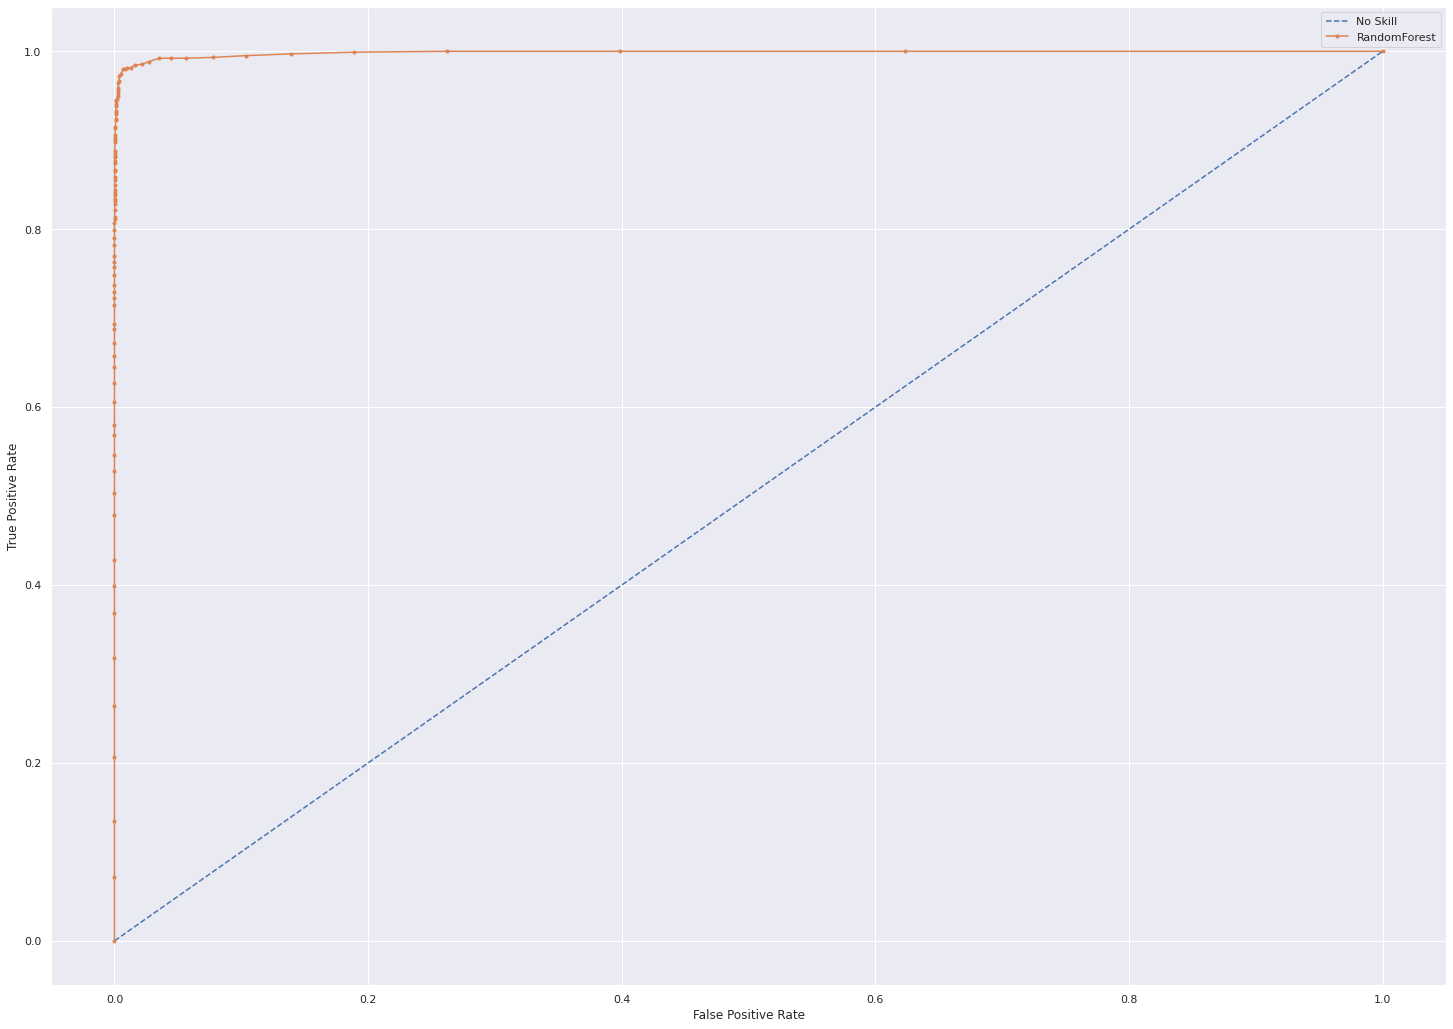

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, y_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('RandomForest: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

NOTE: For Train data:

Precision: 1.0
Recall: 0.89
F1 score: 0.94

Validation data:

Precision: 0.99
Recall: 0.87
F1 score: 0.93

There is no overfitting in the model, however, Decision Tree Classifier has given the best F1 score and in this problem, we would use Decision Tree Classifier as our final model for loan default classification.

This situation has occured mainly because, Decision Tree itself is performing so well without any overfitting, that Random Forest (bagging ensemble) is not required to better the model and thus, it is not able to improve further in the model.

Although, ROC-AUC for RF is much higher as compared to DT.

Still, let's check whether RF performs better after hyper-parameter tuning.

# Random Forest Classifier using Hyper-parameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Random SearchCV for Hyper Parameter Tuning

# Maximum number of levels in tree
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 800, num = 8)]
max_depth = [int(x) for x in np.linspace(5, 25, num = 10)]
max_features = ['auto', 'sqrt', 5, 6, 8, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

train_model = RandomForestClassifier(class_weight = 'balanced')

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores

train_model_random = RandomizedSearchCV(estimator = train_model, param_distributions = random_grid, n_iter = 10, cv = 5, 
                                        verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
train_model_random.fit(X_train,y_train)

print(train_model_random.best_params_)
print(train_model_random.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 25}
RandomForestClassifier(class_weight='balanced', max_depth=25,
                       max_features='sqrt', n_estimators=300)


In [ ]:
acc_scores_rf = []
roc_auc_scores_rf = []
precision_scores_rf = []
recall_scores_rf = []
f1_scores_rf = []
train_acc = []

#Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=0)

#K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_scaled, y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  randomForestClassifier = RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features='sqrt', n_estimators=800)

  randomForestClassifier.fit(X_scaled.iloc[train], y_train.iloc[train])
  y_pred = randomForestClassifier.predict(X_scaled.iloc[test])

  acc_scores_rf.append(accuracy_score(y_train.iloc[test], y_pred))

  train_acc.append(accuracy_score(y_train.iloc[train], randomForestClassifier.predict(X_scaled.iloc[train])))
  roc_auc_scores_rf.append(roc_auc_score(y_train.iloc[test], y_pred))
  precision_scores_rf.append(precision_score(y_train.iloc[test], y_pred))
  recall_scores_rf.append(recall_score(y_train.iloc[test], y_pred))
  f1_scores_rf.append(f1_score(y_train.iloc[test], y_pred))

  fold_no = fold_no + 1
  
print(f"Accuracy Mean: {np.mean(acc_scores_rf)}")
print(f"Accuracy Standard Deviation: {np.std(acc_scores_rf)}")
print("\n")
print(f"ROC-AUC Mean: {np.mean(roc_auc_scores_rf)}")
print(f"ROC-AUC Standard Deviation: {np.std(roc_auc_scores_rf)}")
print("\n")
print(f"Precision Mean: {np.mean(precision_scores_rf)}")
print(f"Precision Standard Deviation: {np.std(precision_scores_rf)}")
print("\n")
print(f"Recall Mean: {np.mean(recall_scores_rf)}")
print(f"Recall Standard Deviation: {np.std(recall_scores_rf)}")
print("\n")
print(f"F1 Mean: {np.mean(f1_scores_rf)}")
print(f"F1 Standard Deviation: {np.std(f1_scores_rf)}")

print(f"train accuracy Mean: {np.mean(train_acc)}")

------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...
------------------------------------------------------------------------
Training for fold 6 ...
------------------------------------------------------------------------
Training for fold 7 ...
------------------------------------------------------------------------
Training for fold 8 ...
------------------------------------------------------------------------
Training for fold 9 ...
------------------------------------------------------------------------
Training for fold 10 ...
Accuracy Mean: 0.984736319115

In [ ]:
X_test1 = X_test.copy()

X_test_scaled = rs.transform(X_test1)

X_test_scaled.shape

y_pred = randomForestClassifier.predict(X_test_scaled)

y_prob = randomForestClassifier.predict_proba(X_test_scaled)[:,1]

X_test1['pred'] = y_pred

X_test1['prob'] = y_prob

print('___________________VALIDATION RESULTS__________________________')
print('\n')
print('Accuracy Score ->',round(accuracy_score(y_test, X_test1['pred']),))
print('Precision Score ->',round(precision_score(y_test, X_test1['pred']),5))
print('Recall Score ->',round(recall_score(y_test, X_test1['pred']),5))
print('F1 Score ->',round(f1_score(y_test, X_test1['pred']),5))
print('\n')
print('***Confusion Matrix***')
confusion_matrix(y_test, X_test1['pred'])

___________________VALIDATION RESULTS__________________________


Accuracy Score -> 1
Precision Score -> 0.99889
Recall Score -> 0.8716
F1 Score -> 0.93091


***Confusion Matrix***


array([[7073,    1],
       [ 132,  896]])

NOTE: Even after hyper-parameter tuning, the model performance did not improve to a great extent.

Therefore, Decision Tree Classifier is the best model to be used in this project as mentioned before.

# Feature Importance Plot for Random Forest model

Text(0.5, 1.0, 'Feature Importance')

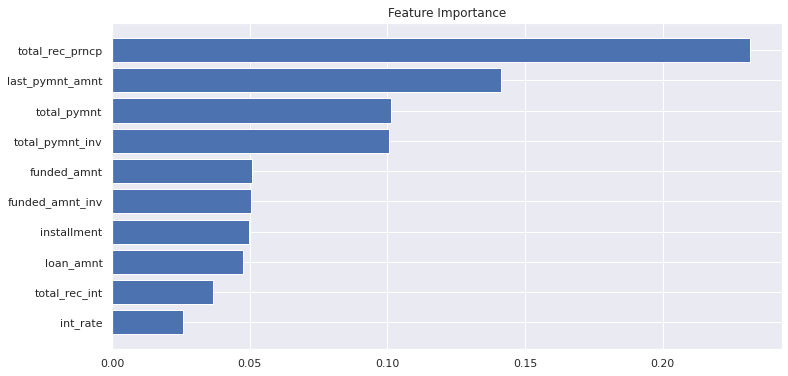

In [ ]:
model=RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features='sqrt', n_estimators=800)
model.fit(X_train,y_train)
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_idx=sorted_idx[-10:len(sorted_idx)]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test1.columns)[sorted_idx])
plt.title('Feature Importance')

# CONCLUSION

In this project, we are able to obtain the best model, that is, Decision Tree, which is able to classify a potential borrower into default or non-default with an F1 score of 0.96. 

This model would help various financial companies to identify typical behaviour in borrowers and predict whether they would be unable to pay their debt before allowing them to borrow and thus reduce their risk of losing money by lending to borrowers who would have high chance of defaulting.